# LSTM Stock Predictor Using Fear and Greed Index

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin fear and greed index values to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

In [23]:
import numpy as np
import pandas as pd
import hvplot.pandas
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [24]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [25]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [26]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [27]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [28]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [29]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [30]:
#function to do below steps
#1)generate of feature data using window size, 
#2)split data for training and testing
#3)Scale and reshape the data
#4)build and train LSTM model
#5)evaluate performance
#6) Predict Closing Prices using a 10 day window of previous fng values

# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1


    
def split_and_scale_data(X,y):
    # Use 70% of the data for training and the remaineder for testing
    split = int(0.7 * len(X))
    X_train = X[: split]
    X_test = X[split:]
    y_train = y[: split]
    y_test = y[split:]
    # Use the MinMaxScaler to scale data between 0 and 1.
    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the MinMaxScaler object with the training feature data X_train
    scaler.fit(X_train)

    # Scale the features training and testing sets
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit the MinMaxScaler object with the training target data y_train
    scaler.fit(y_train)

    # Scale the target training and testing sets
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    return X_train,X_test,y_train,y_test,scaler

def build_LTSM_model(X_train):
    # Build the LSTM model. 
    # The return sequences need to be set to True if you are adding additional LSTM layers, but 
    # You don't have to do this for the final layer. 
    # Note: The dropouts help prevent overfitting
    # Note: The input shape is the number of time steps and the number of indicators
    # Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

    model = Sequential()

    number_units = 30
    dropout_fraction = 0.2

    # Layer 1
    model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
    model.add(Dropout(dropout_fraction))
    # Layer 2
    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    # Layer 3
    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))
    # Output layer
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer="adam", loss="mean_squared_error")
    # Summarize the model
    model.summary()
    return model


def predict_using_LTSM_model(df, window_size, feature_column, target_column):
    X, y = window_data(df, window_size, feature_column, target_column)
    X_train,X_test,y_train,y_test,scaler = split_and_scale_data(X,y)
    # Reshape the features for the model
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    print (f"X_train sample values:\n{X_train[:5]} \n")
    print (f"X_test sample values:\n{X_test[:5]}")
    model = build_LTSM_model(X_train)
    # Train the model
    # Use at least 10 epochs
    # Do not shuffle the data
    # Experiement with the batch size, but a smaller batch size is recommended
    model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)
    # Evaluate the model
    model.evaluate(X_test, y_test)
    # Make some predictions
    predicted = model.predict(X_test)
    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    # Create a DataFrame of Real and Predicted values
    stocks = pd.DataFrame({
        "Real": real_prices.ravel(),
        "Predicted": predicted_prices.ravel()
        }, index = df.index[-len(real_prices): ]) 
    stocks.head()
    return stocks

In [31]:
stocks_window_10 = predict_using_LTSM_model(df, window_size, feature_column, target_column)


X_train sample values:
[[[0.33333333]
  [0.10606061]
  [0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.41538462]
  [0.32307692]
  [0.53846154]
  [0.69230769]]

 [[0.10606061]
  [0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]
  [0.32307692]
  [0.53846154]
  [0.69230769]
  [0.33846154]]

 [[0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]
  [0.33333333]
  [0.53846154]
  [0.69230769]
  [0.33846154]
  [0.50769231]]

 [[0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]
  [0.33333333]
  [0.54545455]
  [0.69230769]
  [0.33846154]
  [0.50769231]
  [0.4       ]]

 [[0.04545455]
  [0.        ]
  [0.42424242]
  [0.33333333]
  [0.54545455]
  [0.6969697 ]
  [0.33846154]
  [0.50769231]
  [0.4       ]
  [0.70769231]]] 

X_test sample values:
[[[0.48484848]
  [0.57575758]
  [0.45454545]
  [0.60606061]
  [0.60606061]
  [0.53030303]
  [0.52307692]
  [0.49230769]
  [0.44615385]
  [0.83076923]]

 [[0.57575758]
  [0.45454545]
  [0.606060

In [32]:
window_size = 20
stocks_window_20 = predict_using_LTSM_model(df, window_size, feature_column, target_column)


X_train sample values:
[[[0.33333333]
  [0.10606061]
  [0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.41538462]
  [0.32307692]
  [0.53846154]
  [0.69230769]
  [0.33846154]
  [0.50769231]
  [0.4       ]
  [0.70769231]
  [0.95384615]
  [0.89230769]
  [1.        ]
  [0.83076923]
  [0.89230769]
  [1.        ]]

 [[0.10606061]
  [0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]
  [0.32307692]
  [0.53846154]
  [0.69230769]
  [0.33846154]
  [0.50769231]
  [0.4       ]
  [0.70769231]
  [0.95384615]
  [0.89230769]
  [1.        ]
  [0.83076923]
  [0.89230769]
  [1.        ]
  [0.69230769]]

 [[0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]
  [0.33333333]
  [0.53846154]
  [0.69230769]
  [0.33846154]
  [0.50769231]
  [0.4       ]
  [0.70769231]
  [0.95384615]
  [0.89230769]
  [1.        ]
  [0.83076923]
  [0.89230769]
  [1.        ]
  [0.69230769]
  [0.53846154]]

 [[0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]
  [0.333333

In [35]:
window_size = 5
stocks_window_5 = predict_using_LTSM_model(df, window_size, feature_column, target_column)


X_train sample values:
[[[0.33333333]
  [0.10606061]
  [0.48484848]
  [0.24242424]
  [0.04545455]]

 [[0.10606061]
  [0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]]

 [[0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]]

 [[0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]
  [0.33333333]]

 [[0.04545455]
  [0.        ]
  [0.42424242]
  [0.33333333]
  [0.54545455]]] 

X_test sample values:
[[[0.60606061]
  [0.60606061]
  [0.53030303]
  [0.53030303]
  [0.5       ]]

 [[0.60606061]
  [0.53030303]
  [0.53030303]
  [0.5       ]
  [0.45454545]]

 [[0.53030303]
  [0.53030303]
  [0.5       ]
  [0.45454545]
  [0.83333333]]

 [[0.53030303]
  [0.5       ]
  [0.45454545]
  [0.83333333]
  [0.86363636]]

 [[0.5       ]
  [0.45454545]
  [0.83333333]
  [0.86363636]
  [0.77272727]]]
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)             

In [36]:
window_size = 50
stocks_window_50 = predict_using_LTSM_model(df, window_size, feature_column, target_column)


X_train sample values:
[[[0.33333333]
  [0.10606061]
  [0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.41538462]
  [0.32307692]
  [0.53846154]
  [0.69230769]
  [0.33846154]
  [0.50769231]
  [0.4       ]
  [0.70769231]
  [0.95384615]
  [0.89230769]
  [1.        ]
  [0.83076923]
  [0.89230769]
  [1.        ]
  [0.77586207]
  [0.60344828]
  [0.51724138]
  [0.37931034]
  [0.4137931 ]
  [0.48275862]
  [0.60344828]
  [0.55172414]
  [0.5       ]
  [0.65517241]
  [0.81034483]
  [0.60344828]
  [0.79310345]
  [0.86206897]
  [0.48275862]
  [0.51724138]
  [0.48275862]
  [0.51724138]
  [0.53448276]
  [0.55172414]
  [0.55172414]
  [0.53448276]
  [0.39655172]
  [0.4137931 ]
  [0.36666667]
  [0.33333333]
  [0.33333333]
  [0.46666667]
  [0.45      ]
  [0.45      ]]

 [[0.10606061]
  [0.48484848]
  [0.24242424]
  [0.04545455]
  [0.        ]
  [0.42424242]
  [0.32307692]
  [0.53846154]
  [0.69230769]
  [0.33846154]
  [0.50769231]
  [0.4       ]
  [0.70769231]
  [0.95384615]
  [0.89230769]


---

<AxesSubplot:title={'center':'Model prediction using FNG index data and rolling window 10'}>

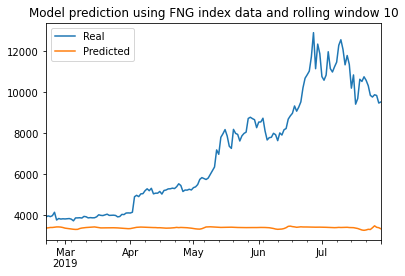

In [49]:
# Plot the real vs predicted values as a line chart
stocks_window_10.plot(title = "Model prediction using FNG index data and rolling window 10")

<AxesSubplot:title={'center':'Model prediction using FNG index data and using rolling window 20'}>

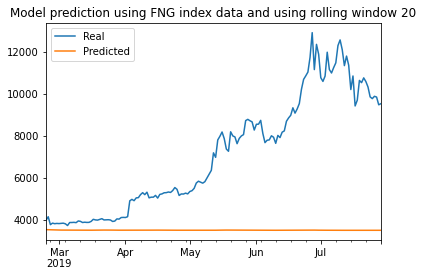

In [48]:
# Plot the real vs predicted values as a line chart
stocks_window_20.plot(title="Model prediction using FNG index data and using rolling window 20")

<AxesSubplot:title={'center':'Model prediction using FNG index data and using rolling window 5'}>

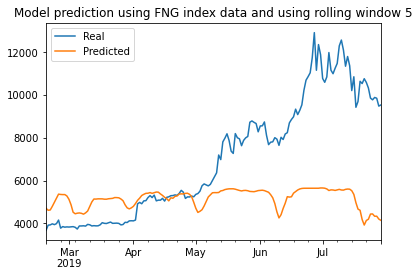

In [47]:
# Plot the real vs predicted values as a line chart
stocks_window_5.plot(title="Model prediction using FNG index data and using rolling window 5")

<AxesSubplot:title={'center':'Model prediction using FNG index data and using rolling window 50'}>

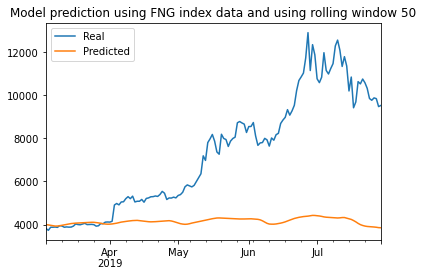

In [50]:
# Plot the real vs predicted values as a line chart
stocks_window_50.plot(title="Model prediction using FNG index data and using rolling window 50")

***This model i.e using fear and greed index is not good to get the predictions. As seen from the above charts for different rollling window of 10,20,5 and 50, none of the predictions are close to the actual values.Comparitively, using the smaller rolling window of 5 is better than using larger rolling window***